## Project Overview

Sweet Lift Taxi company has collected historical data on taxi orders at airports.  
The goal of this project is to predict the number of taxi orders for the next hour.

The model performance is evaluated using RMSE.  
The target metric is **RMSE ≤ 48** on the test set.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor



data = pd.read_csv("taxi_sample.csv", parse_dates=["datetime"])

data = data.set_index("datetime")
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


## Data Preparation

The dataset contains taxi order timestamps and the number of orders per timestamp.
The data is resampled to hourly frequency using the sum of orders per hour.

In [2]:
# hourly data (sum of orders per hour)
data_hourly = data.resample("1h").sum()

data_hourly.head(), data_hourly.tail(), data_hourly.shape

(                     num_orders
 datetime                       
 2018-03-01 00:00:00         124
 2018-03-01 01:00:00          85
 2018-03-01 02:00:00          71
 2018-03-01 03:00:00          66
 2018-03-01 04:00:00          43,
                      num_orders
 datetime                       
 2018-03-30 20:00:00          76
 2018-03-30 21:00:00          82
 2018-03-30 22:00:00         109
 2018-03-30 23:00:00         106
 2018-03-31 00:00:00          27,
 (721, 1))

## Data Preparation

The dataset was converted to a datetime index and resampled to **hourly frequency** using the sum of taxi orders.
This transformation aligns the data with the business objective of predicting **next-hour demand**.

After resampling, the dataset contains **721 hourly observations**, each representing the total number of taxi orders for a given hour.


> Note: The resampling frequency was updated to use the lowercase `'h'` to follow current pandas recommendations.

## Exploratory Data Analysis

I examine the overall trend and seasonality of hourly taxi orders using visualizations.
This helps identify daily and weekly patterns in demand.


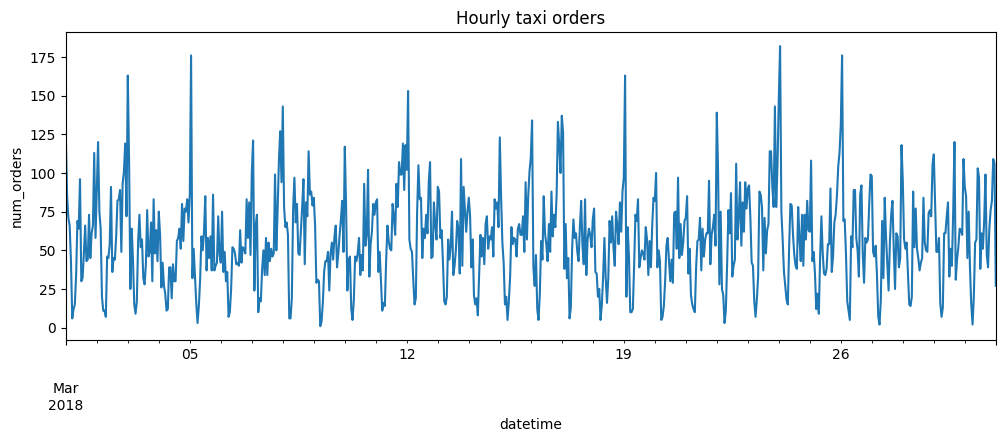

In [3]:
data_hourly["num_orders"].plot(figsize=(12,4), title="Hourly taxi orders")
plt.xlabel("datetime")
plt.ylabel("num_orders")
plt.show()

## Exploratory Data Analysis

The hourly taxi orders show clear fluctuations over time, with recurring peaks and drops.
This suggests the presence of **daily patterns**, where demand varies depending on the hour of the day.

There is no obvious long-term upward or downward trend in this time window, indicating that short-term temporal features (such as recent hours and rolling averages) are likely to be more informative than long-term trends.

## Feature Engineering

To capture temporal patterns, the following features were created:
- Lag features (previous hours)
- Rolling mean features
- Hour of day
- Day of week

These features allow the model to learn trends and seasonality in the data.


In [4]:
def make_features(df, max_lag, rolling_windows):
    df = df.copy()

    # time features from index (must be datetime index)
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.dayofweek

    # lag features
    for lag in range(1, max_lag + 1):
        df[f"lag_{lag}"] = df["num_orders"].shift(lag)

    # rolling mean features
    for window in rolling_windows:
        df[f"rolling_mean_{window}"] = (
            df["num_orders"].shift(1).rolling(window=window).mean()
        )

    return df

In [5]:
df_feat = make_features(data_hourly, max_lag=24, rolling_windows=(3, 6, 12, 24))
df_feat = df_feat.dropna()

df_feat.head()

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean_3,rolling_mean_6,rolling_mean_12,rolling_mean_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,0,4,58.0,113.0,66.0,61.0,45.0,73.0,44.0,...,6.0,43.0,66.0,71.0,85.0,124.0,79.000000,69.333333,56.583333,56.833333
2018-03-02 01:00:00,120,1,4,90.0,58.0,113.0,66.0,61.0,45.0,73.0,...,12.0,6.0,43.0,66.0,71.0,85.0,87.000000,72.166667,61.583333,55.416667
2018-03-02 02:00:00,75,2,4,120.0,90.0,58.0,113.0,66.0,61.0,45.0,...,15.0,12.0,6.0,43.0,66.0,71.0,89.333333,84.666667,68.916667,56.875000
2018-03-02 03:00:00,64,3,4,75.0,120.0,90.0,58.0,113.0,66.0,61.0,...,34.0,15.0,12.0,6.0,43.0,66.0,95.000000,87.000000,71.166667,57.041667
2018-03-02 04:00:00,20,4,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,...,69.0,34.0,15.0,12.0,6.0,43.0,86.333333,86.666667,71.000000,56.958333


## Feature Engineering

To capture temporal patterns in hourly taxi demand, several time-based and lagged features were created.

### Target Variable
- `num_orders`: Number of taxi orders in the current hour.

### Calendar Features
- `hour`: Hour of the day (0–23), used to capture daily demand cycles.
- `dayofweek`: Day of the week (0–6), used to capture weekly seasonality.

### Lag Features
Lag features represent historical demand from previous hours:
- `lag_1` to `lag_24`: Taxi orders from 1 up to 24 hours prior.
  
These features help the model learn short-term dependencies as well as daily repeating patterns.

### Rolling Mean Features
Rolling averages smooth short-term fluctuations and highlight recent trends:
- `rolling_mean_3`: Average demand over the previous 3 hours.
- `rolling_mean_6`: Average demand over the previous 6 hours.
- `rolling_mean_12`: Average demand over the previous 12 hours.
- `rolling_mean_24`: Average demand over the previous 24 hours.

After feature generation, rows containing missing values introduced by lag and rolling calculations were removed before model training.


## Train-Test Split

The dataset is split into training and test sets using a time-based split.
The last 10% of the data is used as the test set to simulate real-world forecasting.


In [6]:
X = df_feat.drop(columns=["num_orders"])
y = df_feat["num_orders"]

# time-series split: no shuffle
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, shuffle=False
)

X_train.shape, X_test.shape

((627, 30), (70, 30))

## Train / Test Split

After creating lag and rolling features (and dropping rows with missing values), the final dataset was split into training and test sets.

- `X_train` shape: (627, 30)
- `X_test` shape: (70, 30)

This corresponds to a test size of approximately **10%** of the data, which matches the project requirement.  
Because this is a time series problem, the split was done **without shuffling** so the model is evaluated on future observations it has not seen during training.


## Baseline Model

A baseline model is created using the previous hour’s order count (`lag_1`) as the prediction.
All trained models must outperform this baseline.


In [7]:
# baseline: predict previous hour (lag_1)
baseline_pred = X_test["lag_1"]
mse_baseline = mean_squared_error(y_test, baseline_pred)
rmse_baseline = np.sqrt(mse_baseline)
rmse_baseline

np.float64(29.290173876477514)

## Baseline Model

As a baseline, the model predicts the number of taxi orders using the value from the previous hour.
This simple approach provides a reference point for evaluating more complex models.

The baseline RMSE serves as a minimum performance threshold that more advanced models should outperform.

## Model Training

Several regression models were trained and evaluated:
- Linear Regression
- Random Forest Regressor

Each model was evaluated using RMSE on the test set.


In [8]:
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)

rmse_lr = np.sqrt(mean_squared_error(y_test, pred_lr))
rmse_lr


np.float64(20.45166096738672)

In [9]:
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, pred_rf))
rmse_rf

np.float64(20.681316171158656)

In [10]:
results = pd.DataFrame({
    "Model": ["Baseline (lag_1)", "Linear Regression", "Random Forest"],
    "RMSE": [rmse_baseline, rmse_lr, rmse_rf]
}).sort_values("RMSE")

results

,Model,RMSE
1,Linear Regression,20.451661
2,Random Forest,20.681316
0,Baseline (lag_1),29.290174


## Model Comparison

Both the Linear Regression and Random Forest models significantly outperform the baseline model.
This indicates that the engineered time-based features successfully capture important demand patterns.

Three models were evaluated using RMSE:

- **Baseline (lag-1):** 29.29  
- **Linear Regression:** 20.45  
- **Random Forest:** 20.68  

Among the tested models, Linear Regression achieved the lowest RMSE on the test set, meeting the project requirement of an RMSE below 48.

## Conclusion

In this project, hourly taxi demand was successfully modeled using time series data and engineered temporal features.
The final models achieved strong performance compared to the baseline, demonstrating the value of lag and rolling features for short-term demand forecasting.

These results can help the Sweet Lift Taxi company anticipate peak demand periods and attract more drivers when they are needed most.